### Model: MobileNetV2
This notebook trains a baseline model with the goal of implementing and training a transfer learning model. This model in particular uses data that has not been augmented and will later be compared against the same model using augmented data.

## Import Libraries & Load Data

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from data_loader import load_dir, split_data, create_dataset, data_augmentation

2024-08-07 16:09:47.761546: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 16:09:47.762850: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 16:09:47.770209: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 16:09:47.783285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 16:09:47.801895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
# define 
classes = ['buildings', 'street']
train_dir = 'first_100/seg_train/seg_train'
test_dir = 'first_100/seg_test/seg_test'
max_images = 50  # Number of images per class

image_size=(224,224)
num_classes=2

In [4]:
# Load images and labels
train_images, train_labels = load_dir(train_dir, classes, max_images, image_size)
test_images, test_labels = load_dir(test_dir, classes, max_images, image_size)

In [5]:
# Print the number of files found
total_files = len(train_images) + len(test_images)
print(f"Found {total_files} files belonging to {len(classes)} classes.")

# Split the training data into train and validation sets
train_images, train_labels, val_images, val_labels = split_data(train_images, train_labels, val_split=0.2)

# Print the number of files used for training and validation
print(f"Using {len(train_images)} files for training.")
print(f"Using {len(val_images)} files for validation.")

Found 200 files belonging to 2 classes.
Using 80 files for training.
Using 80 files for validation.


In [6]:
# Create train and validation datasets
train_ds = create_dataset(train_images, train_labels, batch_size=10)
val_ds = create_dataset(val_images, val_labels, batch_size=10)

test_ds = create_dataset(test_images, test_labels, batch_size=10)

In [7]:
# verify shapes
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)

for images, labels in test_ds.take(1):
    print("Test batch shape:", images.shape, labels.shape)

Train batch shape: (10, 224, 224, 3) (10,)
Test batch shape: (10, 224, 224, 3) (10,)


2024-08-07 16:09:53.534896: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-07 16:09:53.586029: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Train Model

In [8]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [9]:
model = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [10]:
epochs = 80

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4), # changed to updated optimizer API
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - acc: 0.4247 - loss: 1.0714 - val_acc: 0.3875 - val_loss: 0.7888
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - acc: 0.4117 - loss: 0.7362 - val_acc: 0.5625 - val_loss: 0.6331
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - acc: 0.5546 - loss: 0.6403 - val_acc: 0.6625 - val_loss: 0.5861
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - acc: 0.6818 - loss: 0.5756 - val_acc: 0.7125 - val_loss: 0.5669
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - acc: 0.7460 - loss: 0.5338 - val_acc: 0.7250 - val_loss: 0.5378
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - acc: 0.7440 - loss: 0.5327 - val_acc: 0.7625 - val_loss: 0.5077
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - acc: 0.7269 - loss: 0.6003 - val_acc: 0.8000 - val_loss: 0.4800
Epoch 8/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - acc: 0.7475 - loss: 0.4939 - val_acc: 0.7625 - val_loss: 0.4558
Epoch 9/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - acc: 0.7431 - loss: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - acc: 0.9394 - loss: 0.1515 - val_acc: 0.9875 - val_loss: 0.1161
Epoch 56/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - acc: 0.9767 - loss: 0.1244 - val_acc: 0.9875 - val_loss: 0.1137
Epoch 57/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - acc: 0.9910 - loss: 0.1260 - val_acc: 0.9875 - val_loss: 0.1114
Epoch 58/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - acc: 0.9683 - loss: 0.1248 - val_acc: 0.9875 - val_loss: 0.1097
Epoch 59/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - acc: 0.9766 - loss: 0.1336 - val_acc: 0.9875 - val_loss: 0.1072
Epoch 60/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - acc: 0.9803 - loss: 0.1384 - val_acc: 0.9875 - val_loss: 0.1049
Epoch 61/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - acc: 0.9938 - loss: 0.0868 - val_acc: 0.9875 - val_loss: 0.1030
Epoch 62/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - acc: 0.9739 - loss: 0.1037 - val_acc: 0.9875 - val_loss: 0.1012
Epoch 63/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - acc: 0.9956 - loss: 0.1

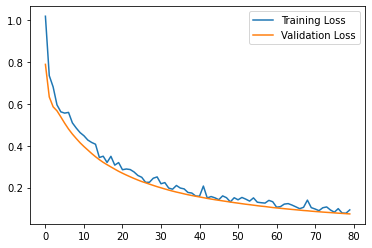

In [11]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

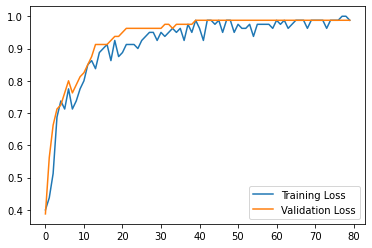

In [12]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [13]:
# save model

model_dir='Models'
os.makedirs(model_dir,exist_ok=True)

model_path=os.path.join(model_dir,'BaseModel.keras')
model.save(model_path)